# Studies of data reuse: Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates (v1)

In this notebook we will look more closely at the EBRAINS dataset "[Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates (v1)](https://search.kg.ebrains.eu/?category=Dataset&modality[0]=electrophysiology&dataAccessibility[0]=free%20access#bd5f91ff-e829-4b85-92eb-fc56991541f1)", contributed by Hélène Marie from the Université Côte d’Azur in Valbonne, France.

As we can see from the dataset description,

<i>This dataset provides an analysis of the intrinsic electrophysiological properties of CA1 excitatory hippocampal
neurons in a mouse model of Alzheimer’s Disease (AD) at two age points: a presymptomatic age (3-4
months) and a symptomatic age: (9-10 months).</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/bd5f91ff-e829-4b85-92eb-fc56991541f1).

This dataset forms part of the results reported in BVitale, P., Salgueiro-Pereira, A. R., Lupascu, C. A., Willem, M., Migliore, R., Migliore, M., & Marie, H.(2021) Analysis of Age-Dependent Alterations in Excitability Properties of CA1 Pyramidal Neurons in an APPPS1 Model of Alzheimer’s Disease. *Frontiers in Aging Neuroscience* **13** https://doi.org/10.3389/fnagi.2021.668948

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 


We used the Neo library (https://neo.readthedocs.io/en/stable/#) to extract the electrophysiological properties.

- Each file consists of an average of 13 segments corresponding to current injection steps from -200 to 400pA in 50pA increments.
- To extract the parameters the authors used the eFel library (https://efel.readthedocs.io/en/latest/eFeatures.html#)
- The cellular response takes place between 80 and 550 ms.

In [10]:
index0=-200
index1=-150
index2=-100
index3=-50
index4=0
index5=50
index6=100
index7=150
index8=200
index9=250
index10=300
index11=350
index12=400

In [11]:
#preparing the notebook
import neo
import matplotlib.pyplot as plt
from neo import get_io
from neo import io
import numpy as np
from statistics import mean
import statistics
import glob
!pip install efel
import efel

In [12]:
#from Elodie's work on this publication: 
data = {}

for file_path in glob("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/*/*.abf"):
    data[file_path] = get_io(file_path).read(lazy=True)[0]

    for i, segment in enumerate(data[file_path].segments):
        
        if i >=5 and i <=7:
            ch0 = data[file_path].segments[i].filter(channel_id=0)[0].load()
            ch0.array_annotations = {}
            time=(ch0.times-ch0.t_start)*1000
            time=time.magnitude
            voltage=ch0.magnitude.flatten()
            stim_start = 80
            stim_end = 550
            trace = {'T': time, 'V': voltage, 'stim_start': [stim_start], 'stim_end': [stim_end]}
            feature_values = efel.getFeatureValues([trace], ['sag_amplitude'])[0]
            if feature_values['sag_amplitude'] is not None:
                print(file_path,":","segment:",i,":",feature_values['sag_amplitude'])

TypeError: 'module' object is not callable

Note pour Andrew:  
la feature "sag amplitude" renvoie une liste de 1 valeur pour chaque segment.Hors pour faire un box plot, il faut une liste de plusieurs valeurs.Comment les auteurs ont-ils fait?

There was no file for 1 month old mouse due to this missing data it was impossible to reproduce some figures
also unsure how they were able to count the number of spikes in each dataset


In [13]:
#presentation of the data

reader = neo.io.ExampleIO("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
block = reader.read(lazy=False)[0]  # get the first block
segment = block.segments[1]         # get data from first (and only) segment
signals = segment.analogsignals[1]  # get first (multichannel) signal

print(reader)
print(block)
print(segment)
print(signals)

ExampleIO: ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf
nb_block: 2
nb_segment:  [2, 3]
signal_streams: [stream 0 (chans: 8), stream 1 (chans: 8)]
signal_channels: [ch0, ch1, ch2, ch3 ... ch12 , ch13 , ch14 , ch15]
spike_channels: [unit0, unit1, unit2]
event_channels: [Some events, Some epochs]

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] uV


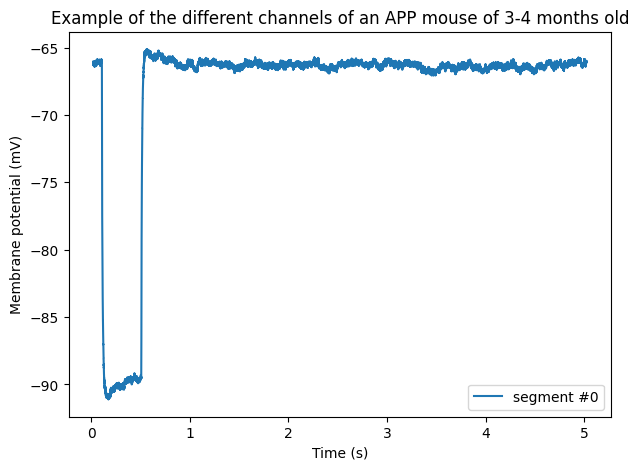

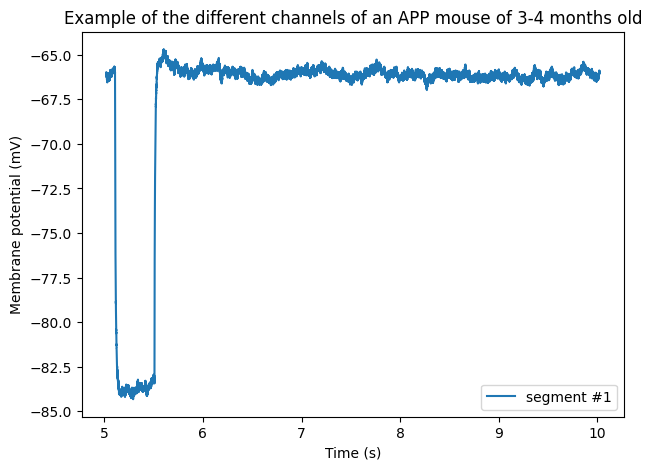

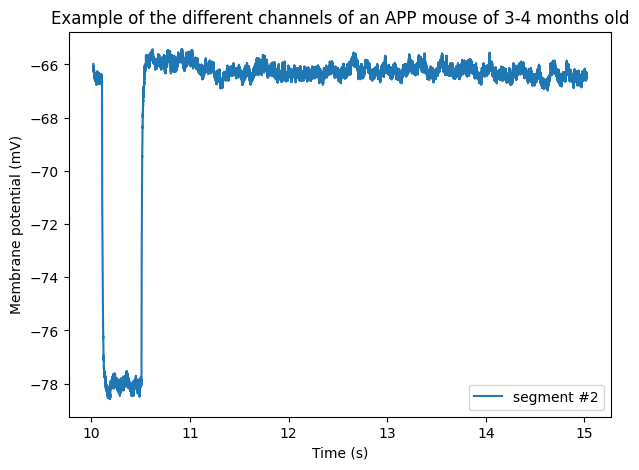

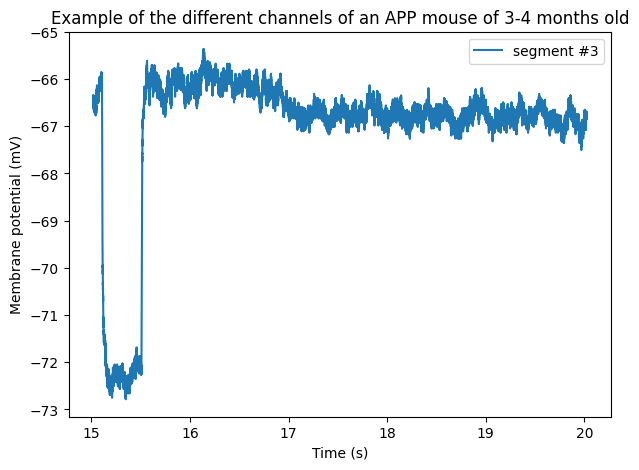

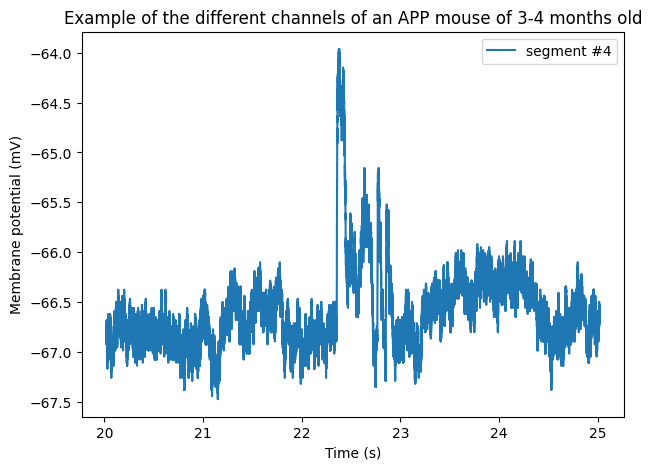

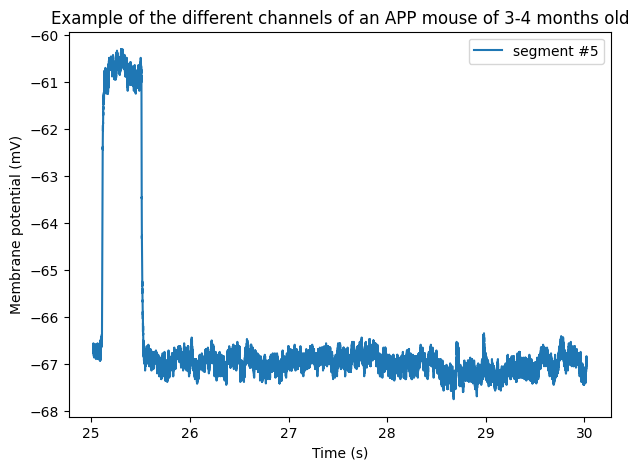

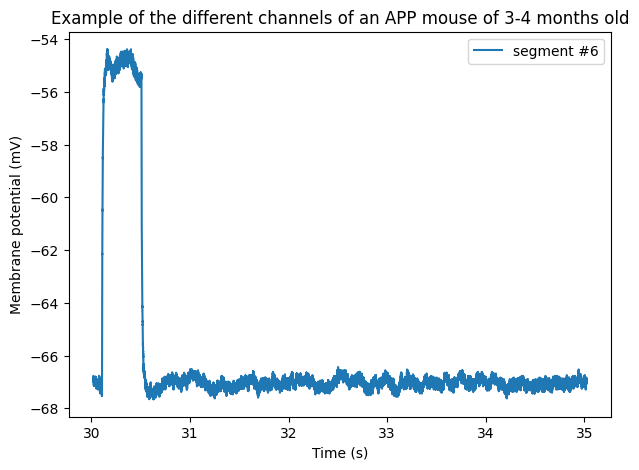

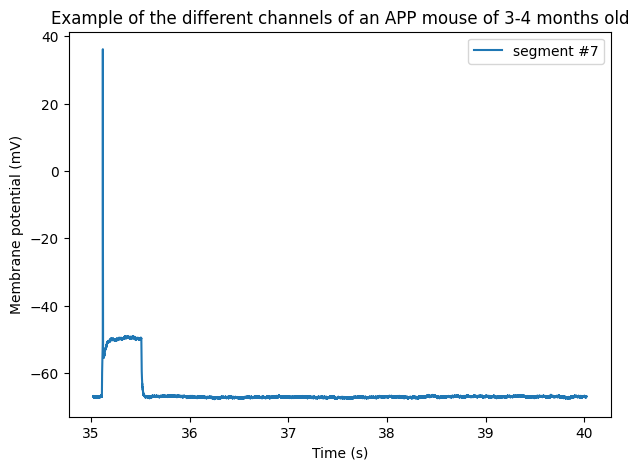

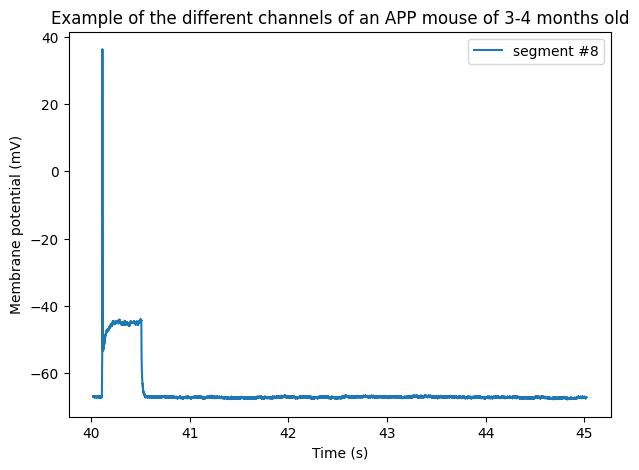

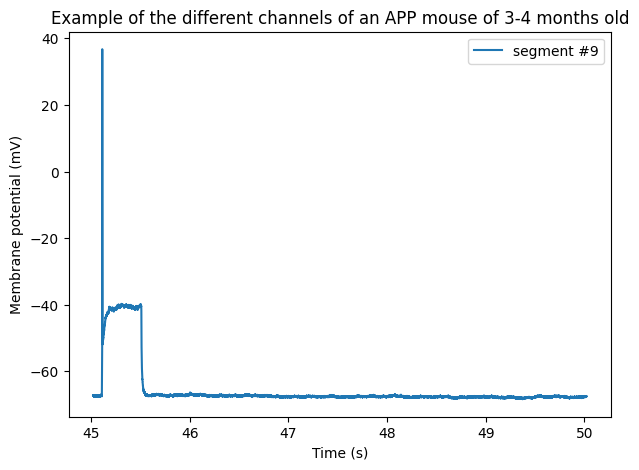

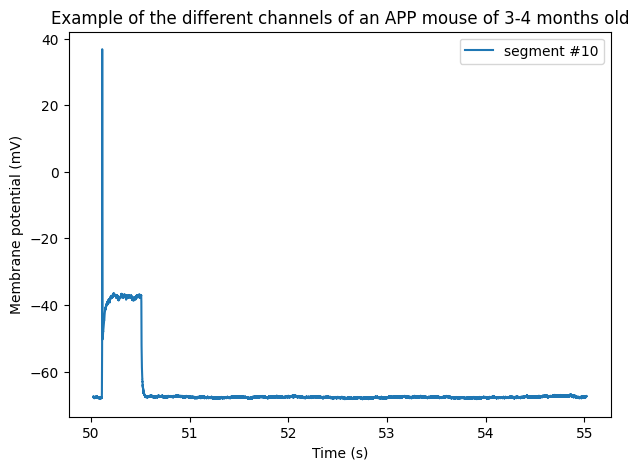

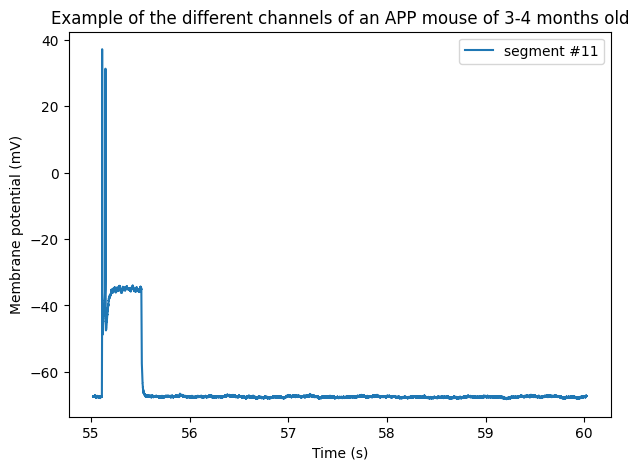

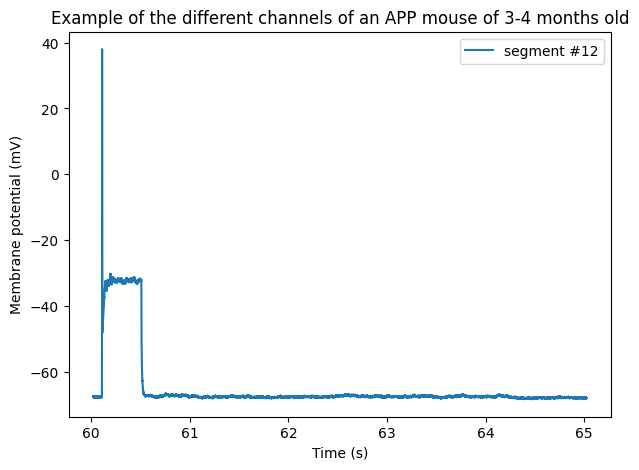

In [14]:
#visualisation of the data, 
n=0
while n<13:
    plt.rcParams["figure.figsize"] = (7, 5)
    file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
    reader = get_io(file_path)
    data = reader.read(lazy=True)
    reader = get_io(file_path)
    data = reader.read(lazy=True)
    seg0 = data[0].segments[(n)]
    channel0 = seg0.analogsignals[0]
    channel0 = channel0.load()
    channel0.array_annotations = {}
    plt.plot(channel0.times, channel0, label=f"segment #{n}")
    plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
    plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
    plt.legend()
    plt.title("Example of the different channels of an APP mouse of 3-4 months old")
    plt.show()
    n=n+1

### Figure 2b
Native resting potential of individual neurons for the different conditions. Average values are shown as closed symbols

In [17]:
list1=[]
list2=[]
list3=[]
list4=[]
list_name=[list1,
           list2,
           list3,
           list4]

filelist=["ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/*.abf",
          "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_9-10_months/*.abf",
          "ext-d000001_ADNeuronModel_pub/control_3-4_months/*.abf",
          "ext-d000001_ADNeuronModel_pub/control_9-10_months/*.abf"]  

z=0
while z<4:

    
    filepath=filelist[z]
    def membrane_mean(file):
        n=0
        list2=[]
        
        while n<(13):
            
            file_path = (file)
            reader = get_io(file_path)
            data = reader.read(lazy=True)
            reader = get_io(file_path)
            data = reader.read(lazy=True)
            seg0 = data[0].segments[(n)]
            channel0 = seg0.analogsignals[0]
            channel0 = channel0.load()
            channel0.array_annotations = {}
            i=0
            list=[]
            while i<(len(channel0)):
                e=channel0[(i)]
                e=e.item()
                list.append(e)
                i=i+1
            a=mean(list)
            list2.append(a)
            n=n+1
        (list_name[z]).append(mean(list2))
        
    list_of_files=(glob.glob(filepath)) 
    x=0
    while x<(len(list_of_files)):
        membrane_mean(list_of_files[x])
        x=x+1
    z=z+1

    


<function matplotlib.pyplot.show(close=None, block=None)>

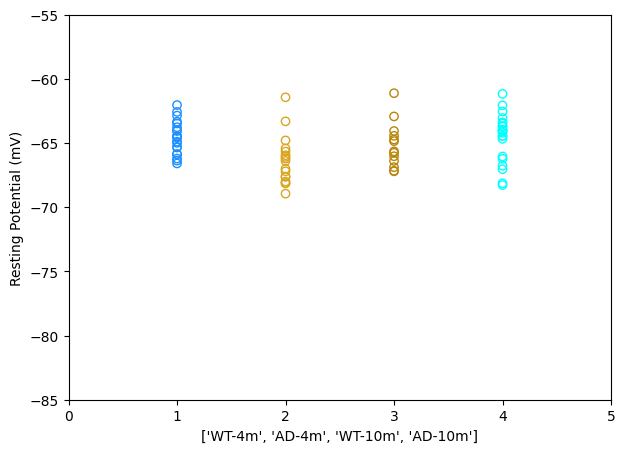

In [18]:
x = [2] * (len(list1))
x2 = [4] * (len(list2))
x3 = [3] * (len(list3))
x4 = [1] * (len(list4))


x_list=['WT-4m','AD-4m','WT-10m','AD-10m']
plt.scatter(x2,list2,facecolors='none',edgecolors='aqua')
plt.plot(mean(list2),4,c='aqua')

plt.scatter(x,list1,facecolors='none',edgecolors='goldenrod')
plt.plot(mean(list1),2,c='goldenrod')


plt.scatter(x3,list3,facecolors='none',edgecolors='darkgoldenrod')
plt.plot(mean(list3),3,c='darkgoldenrod')

plt.scatter(x4,list4,facecolors='none', edgecolors='dodgerblue')
plt.plot(mean(list4),1,c='dodgerblue')
plt.xlim(0,5)
plt.ylim(-85,-55)
plt.ylabel('Resting Potential (mV)')
plt.xlabel(x_list)
plt.show

### Figure 3B
Comparison between model (colored) and experimental (gray) traces under Control and AD conditions for 1, 3–4, and 9–10 months,

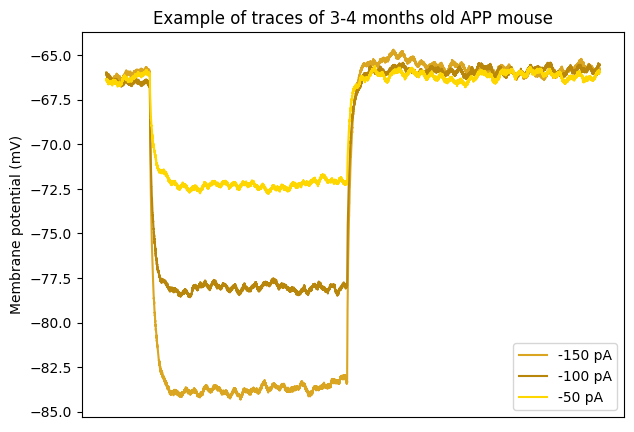

In [19]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[(1)]
channel1 = seg0.analogsignals[0]
channel1 = channel1.load()
channel1.array_annotations = {}
plt.plot(channel1.times[:10000], channel1[:10000], label=f"-150 pA",c='goldenrod')
file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[(2)]
channel2 = seg0.analogsignals[0]
channel2 = channel2.load()
channel2.array_annotations = {}
plt.plot(channel1.times[:10000], channel2[:10000], label=f"-100 pA",c='darkgoldenrod')
file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[(3)]
channel3 = seg0.analogsignals[0]
channel3 = channel3.load()
channel3.array_annotations = {}
plt.plot(channel1.times[:10000], channel3[:10000], label=f"-50 pA",c='gold')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.title("Example of traces of 3-4 months old APP mouse")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)


### Figure 3D
Comparison between model (colored) and experimental (gray) traces under Control and AD conditions for 1, 3–4, and 9–10 months

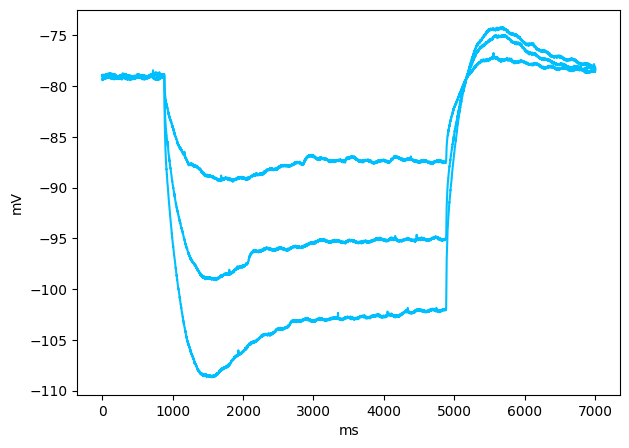

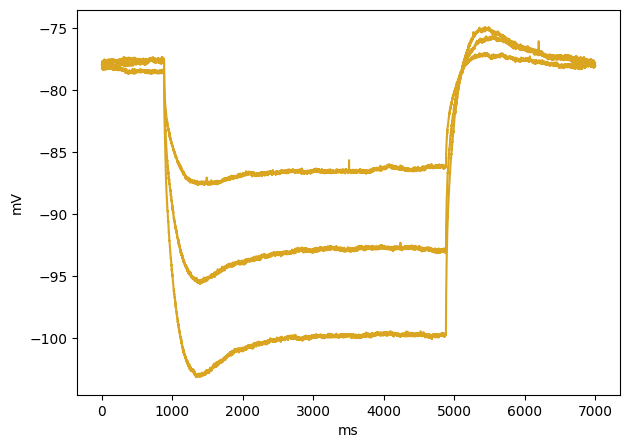

In [22]:
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_WT10m_50.txt")
import pandas as pd
df = pd.DataFrame(iris, columns = ['Column_A','Column_B'])
plt.plot(df['Column_B'],c='deepskyblue')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_WT10m_100.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B1'])
plt.plot(df['Column_B1'],c='deepskyblue')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_WT10m_150.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B2'])
plt.plot(df['Column_B2'],c='deepskyblue')
plt.ylabel('mV')
plt.xlabel('ms')
plt.show()


iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_AD10m_50.txt")
import pandas as pd
df = pd.DataFrame(iris, columns = ['Column_A','Column_B'])
plt.plot(df['Column_B'],c='goldenrod')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_AD10m_100.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B1'])
plt.plot(df['Column_B1'],c='goldenrod')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_AD10m_150.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B2'])
plt.plot(df['Column_B2'],c='goldenrod')
plt.ylabel('mV')
plt.xlabel('ms')
plt.show()


### Figure 5a
Overlap of typical traces for the different conditions.

<function matplotlib.pyplot.show(close=None, block=None)>

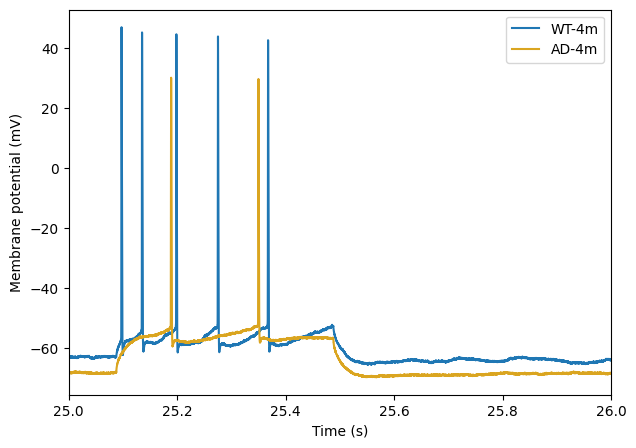

In [23]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_3-4_months/191129002_rita_S24.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[5]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-4m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(25,26)
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129007_rita_S23.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[5]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-4m", c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(25,26)
plt.show

(55.05, 55.5)

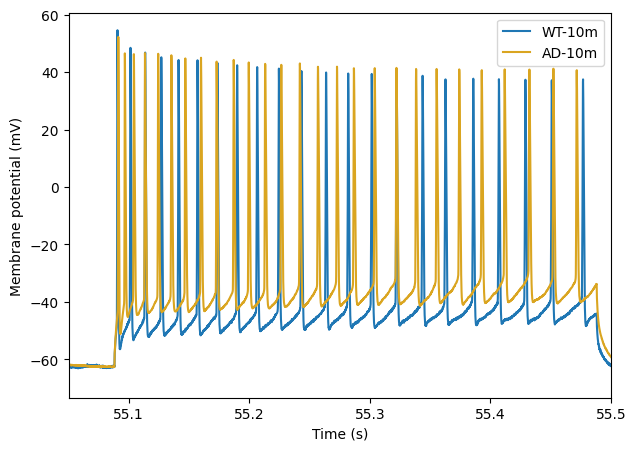

In [24]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_9-10_months/191121004_rita_S76.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[11]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-10m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_9-10_months/200120007_S87.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[11]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-10m",c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(55.05,55.5)

### Figure 6a
Enlargement of the traces to illustrate first 11 spikes in typical experimental traces at 300 pA for each age, under Control and AD conditions.

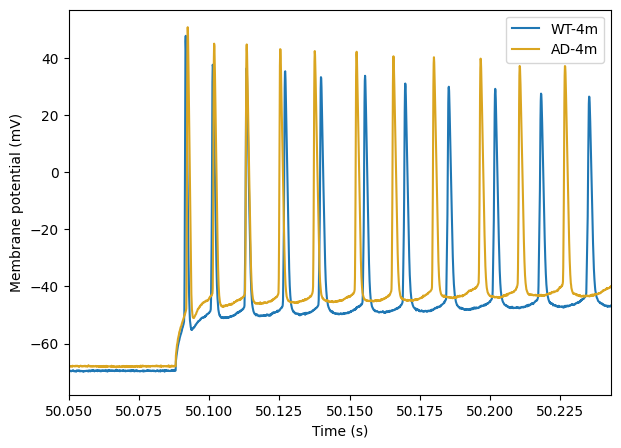

In [27]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191202009_rita_S22.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-4m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()

plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_3-4_months/191129005_rita_S24.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-4m",c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(50.05,50.243)
plt.show()

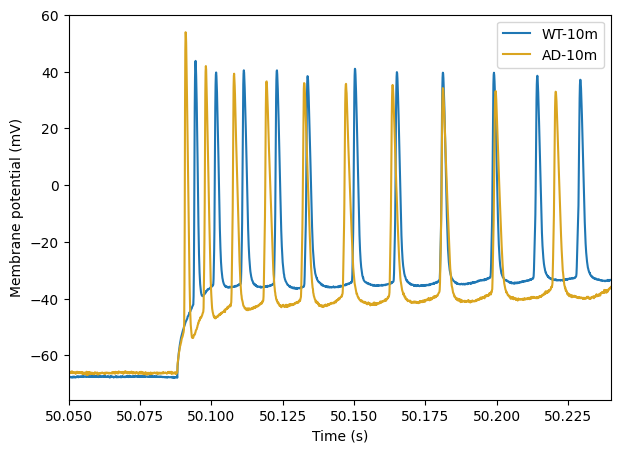

In [28]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_9-10_months/191122000_rita_S77.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-10m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_9-10_months/191121000_rita_S76.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-10m",c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(50.05,50.24)
plt.show()